# Classificazione ECG: punto 1
Si applica il modello proposto dal paper che è definito nella funzione create_model() e consiste di 10 layers.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import Sequential,utils, regularizers, initializers, optimizers
from tensorflow.keras.layers import Flatten, Dense, Conv1D, MaxPool1D, Dropout, Softmax
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from scipy.signal import find_peaks
from tensorflow import keras
import tensorflow as tf

Rifacciamo il download dei dati e li reinseriamo nei vettori di train, test e validation

In [ ]:
meta = pd.read_csv(r'C:\Users\bianc\Desktop\Reti neurali\meta.csv', header = None, error_bad_lines=False)
meta = pd.DataFrame(meta)

In [ ]:
num_battiti = []
X = []
for i in patients:
    if i < 10:
        file = 'ECG_lead2_patient00%i.npy' % i
    elif i < 100 and i > 9:
        file = 'ECG_lead2_patient0%i.npy' % i
    else:
        file = 'ECG_lead2_patient%i.npy' % i
    a = np.load(file, allow_pickle=True)
    c = 0
    for i in a:
        X.append(i)
        c+=1
    num_battiti.append(c)
    
num_battiti = np.array(num_battiti)
X = np.array(X)
print(num_battiti)

In [ ]:
num_battiti_MI = np.zeros(294) # numero di battiti per ogni file dei pazienti con infarto del miocardio
X_MI = [] #ECG corrispondenti
for i in range(1, 550):
    p = int(meta.iloc[i][0].split('t')[2])
    file = 'ECG%i.npy' % i
    try:
        a = np.load(file, allow_pickle=True)
        c = 0
        for i in a:
            X_MI.append(i)
            c+=1
        num_battiti_MI[p-1] += c
    except:
        print('File does not exist')
    
num_battiti_MI = num_battiti_MI.astype(int)
X_MI = np.array(X_MI)
print(num_battiti_MI)
print(num_battiti_MI.size)

In [ ]:
X_total = np.concatenate((X, X_MI))
X_total.shape

In [ ]:
y_label = []
for i in patients:
    if i < 10:
        line = 'patient00%i' % i
    elif i < 100 and i > 9:
        line = 'patient0%i' % i
    else:
        line = 'patient%i' % i
    for i in range(1, 550):
        if meta.iloc[i][0] == line:
            if meta.iloc[i][13] == 'Myocardial infarction':
                if meta.iloc[i][14] == 'anterior':
                    label = 1
                elif meta.iloc[i][14] == 'infero-latera' or meta.iloc[i][14] == 'infero-lateral':
                    label = 2
                elif meta.iloc[i][14] == 'antero-lateral':
                    label = 3
                elif meta.iloc[i][14] == 'inferior':
                    label = 4
                elif meta.iloc[i][14] == 'antero-septal':
                    label = 5
                elif meta.iloc[i][14] == 'infero-posterior-lateral' or meta.iloc[i][14] == 'infero-postero-lateral' or meta.iloc[i][14] == 'infero-poster-lateral':
                    label = 6
                elif meta.iloc[i][14] == 'postero-lateral':
                    label = 7
                elif meta.iloc[i][14] == 'posterior':
                    label = 8
                elif meta.iloc[i][14] == 'lateral':
                    label = 9
                elif meta.iloc[i][14] == 'infero-posterior':
                    label = 10
                elif meta.iloc[i][14] == 'antero-septo-lateral':
                    label = 11
            elif meta.iloc[i][13] == 'Healthy control':
                label = 0
            y_label.append(label)
            break
            
y_label = np.array(y_label)
y_label.size

In [ ]:
y_label_new = []
for i in range(y_label.size):
    for j in range(num_battiti[i]):
        y_label_new.append(y_label[i])
        
y_label = np.array(y_label_new)
y_label.size

In [ ]:
y_label_MI = np.zeros(294) #creazione dei vettori di label
for j in MI_MoreThanOne:
    if j < 10:
        line = 'patient00%i' % j
    elif j < 100 and i > 9:
        line = 'patient0%i' % j
    else:
        line = 'patient%i' % j
    for i in range(1, 550):
        if meta.iloc[i][0] == line:
            if meta.iloc[i][13] == 'Myocardial infarction':
                if meta.iloc[i][14] == 'anterior':
                    label = 1
                elif meta.iloc[i][14] == 'infero-latera' or meta.iloc[i][14] == 'infero-lateral':
                    label = 2
                elif meta.iloc[i][14] == 'antero-lateral':
                    label = 3
                elif meta.iloc[i][14] == 'inferior':
                    label = 4
                elif meta.iloc[i][14] == 'antero-septal':
                    label = 5
                elif meta.iloc[i][14] == 'infero-posterior-lateral' or meta.iloc[i][14] == 'infero-postero-lateral' or meta.iloc[i][14] == 'infero-poster-lateral':
                    label = 6
                elif meta.iloc[i][14] == 'postero-lateral':
                    label = 7
                elif meta.iloc[i][14] == 'posterior':
                    label = 8
                elif meta.iloc[i][14] == 'lateral':
                    label = 9
                elif meta.iloc[i][14] == 'infero-posterior':
                    label = 10
                elif meta.iloc[i][14] == 'antero-septo-lateral':
                    label = 11
            elif meta.iloc[i][13] == 'Healthy control':
                label = 0
            y_label_MI[j-1] += label
            break
            
y_label_MI = y_label_MI.astype(int)
y_label_MI.size

In [ ]:
#togliamo gli zeri
y_label_new = []
num_battiti_new = []
for i in range(y_label_MI.size):
    if y_label_MI[i] != 0:
        y_label_new.append(y_label_MI[i])
        num_battiti_new.append(num_battiti_MI[i])
        
y_label_MI = np.array(y_label_new)
num_battiti_MI = np.array(num_battiti_new)
print(y_label_MI.size)
print(num_battiti_MI.size)

In [ ]:
#creiamo il vettore di label per gli MI
y_label_new = []
for i in range(y_label_MI.size):
    for j in range(num_battiti_MI[i]):
        y_label_new.append(y_label_MI[i])
        
y_label_MI = np.array(y_label_new)
y_label_MI.size

In [ ]:
Y_total = np.concatenate((y_label, y_label_MI))

In [ ]:
#togliamo i battiti sottocampionati
X_total_new = []
Y_total_new = []
for i in range(X_total.shape[0]):
    if X_total[i].size==650:
        X_total_new.append(X_total[i])
        Y_total_new.append(Y_total[i])
X_total = np.array(X_total_new)
Y_total = np.array(Y_total_new)
print(X_total.shape)
print(Y_total.size)

In [ ]:
N = X_total.shape[0]

n = np.arange(N)

import random
cut = int(0.85 * N) #85% del totale
random.shuffle(n)
X_train_index = n[:cut] # first 85% train
X_test_index = n[cut:] # last 15% test

cut1 = int(0.128 * len(X_train_index))
random.shuffle(X_train_index)
X_train_index = X_train_index[cut1:] # last 70% train
X_val_index = X_train_index[:cut1] # first 15% validation

X_test_index = np.array(X_test_index)
X_train_index = np.array(X_train_index)
X_val_index = np.array(X_val_index)

In [ ]:
Xtrain = []
Ytrain = []
Xval = []
Yval = []
Xtest = []
Ytest = []
for i in X_train_index:
    Xtrain.append(X_total[i])
    Ytrain.append(Y_total[i])
for i in X_test_index:
    Xtest.append(X_total[i])
    Ytest.append(Y_total[i])
for i in X_val_index:
    Xval.append(X_total[i])
    Yval.append(Y_total[i])
    
Xtrain = np.array(Xtrain, dtype=object)
Ytrain = np.array(Ytrain, dtype=object)
Xtest = np.array(Xtest, dtype=object)
Ytest = np.array(Ytest, dtype=object)
Xval = np.array(Xval, dtype=object)
Yval = np.array(Yval, dtype=object)

In [ ]:
def create_model(optimizer, activation='relu'):
    model = Sequential()
    model.add(Conv1D(64, 5, strides=1, input_shape = input_shape, activation=activation))
    model.add(Conv1D(128, 3, strides=1, activation=activation))
    model.add(MaxPool1D(pool_size=2, strides=2))
    model.add(Dropout(0.2))
    model.add(Conv1D(128, 13, strides=1, activation=activation))
    model.add(Conv1D(256, 7, strides=1, activation=activation))
    model.add(MaxPool1D(pool_size=2, strides=2))
    model.add(Flatten())
    model.add(Dense(12, activation = activation))
    model.add(Softmax())
    
    print(model.summary())

    model.compile(loss = keras.losses.categorical_crossentropy, optimizer = optimizer, metrics = ['accuracy']) 
    
    return model

# Rete senza data augmentation
Si applica la rete ai dati ottenuti dal punto0 

In [100]:
print('shape train before: ',Xtrain.shape)
Xtrain = Xtrain.reshape(Xtrain.shape[0],Xtrain[0].size,1)
print('shape train after: ',Xtrain.shape)
print('shape validation before: ',Xval.shape)
Xval = Xval.reshape(Xval.shape[0],Xval[0].size,1)
print('shape validation before: ',Xval.shape)
input_shape = (Xtrain[0].size,1)

batch_size = 64
epochs = 50

shape train before:  (52015, 650)
shape train after:  (52015, 650, 1)
shape validation before:  (7635, 650)
shape validation before:  (7635, 650, 1)


In [101]:
#transform integer label into one-hot encodings
n_classes=12

Ytrain_cat = keras.utils.to_categorical(Ytrain, n_classes)
Yval_cat = keras.utils.to_categorical(Yval, n_classes)
Ytest_cat = keras.utils.to_categorical(Ytest, n_classes)

In [102]:
Xtrain = np.asarray(Xtrain).astype('float32')
Xval = np.asarray(Xval).astype('float32')

In [103]:
opt = optimizers.SGD(lr = 0.01, momentum = 0.9, nesterov = True, decay = 1e-6)
model2 = create_model(opt)

fit = model2.fit(Xtrain, Ytrain_cat,
               batch_size = batch_size, epochs = epochs,
               validation_data = (Xval, Yval_cat),
               verbose = 1, shuffle = True)

SGD2 = np.array((fit.history["accuracy"],
                       fit.history['val_' + "accuracy"],
                       fit.history["loss"], fit.history['val_' + "loss"]))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 646, 64)           384       
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 644, 128)          24704     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 322, 128)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 322, 128)          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 310, 128)          213120    
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 304, 256)          229632    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 152, 256)         

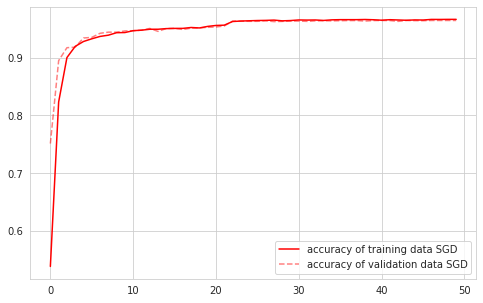

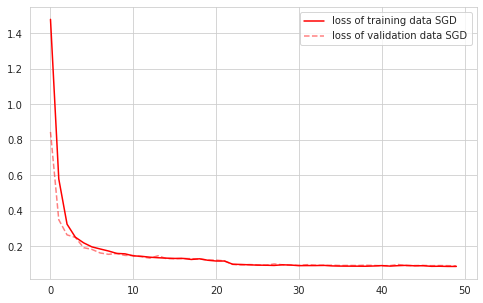

In [104]:
i=0
plt.plot(SGD2[i], 'r', label = 'accuracy of training data SGD')
plt.plot(SGD2[i+1], 'r--', label = 'accuracy of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()

i=2
plt.plot(SGD2[i], 'r', label = 'loss of training data SGD')
plt.plot(SGD2[i+1], 'r--', label = 'loss of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()

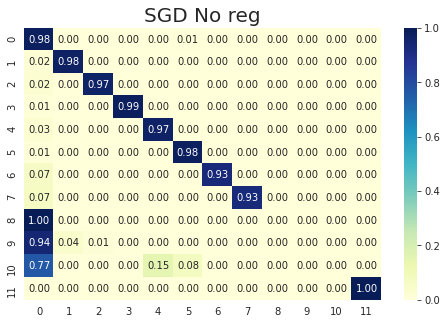

In [105]:
import sklearn.metrics as skm
from sklearn.metrics import plot_confusion_matrix

test = Xtest.reshape(Xtest.shape[0],Xtest[0].size,1)
y_val_vect = Ytest.astype(int)
y_predict  = np.argmax(model2.predict(test.astype(float)), axis=-1)

confusion_matrix  = skm.confusion_matrix(y_val_vect ,y_predict, normalize='true')

ax = sns.heatmap(confusion_matrix, annot=True, fmt = '.2f', cmap="YlGnBu")
ax.set_title('SGD No reg', fontsize=20)
plt.show()

Come vediamo dai grafici dell'accuracy e della loss non si osserva overfitting ma applicando la confusion matrix ai dati di test vediamo che il modello sbaglia nell'identificazione dei label 8, 9, 10 (P, L, IP) confondendoli con quelli sani H.

# Rete con data augmentation
Si opera una data augmentation per rendere uniforme il nostro dataset ed evitare il mismatch dei dati.

In [106]:
Xtrain = []
Ytrain = []
Xval = []
Yval = []
Xtest = []
Ytest = []
for i in X_train_index:
    Xtrain.append(X_total[i])
    Ytrain.append(Y_total[i])
for i in X_test_index:
    Xtest.append(X_total[i])
    Ytest.append(Y_total[i])
for i in X_val_index:
    Xval.append(X_total[i])
    Yval.append(Y_total[i])
    
Xtrain = np.array(Xtrain, dtype=object)
Ytrain = np.array(Ytrain, dtype=object)
Xtest = np.array(Xtest, dtype=object)
Ytest = np.array(Ytest, dtype=object)
Xval = np.array(Xval, dtype=object)
Yval = np.array(Yval, dtype=object)

In [107]:
#Applico una maschera sui vettori Xtrain. Seleziono quelli con un determinato label
df_0  = Xtrain[Ytrain == 0]
df_1  = Xtrain[Ytrain == 1]
df_2  = Xtrain[Ytrain == 2]
df_3  = Xtrain[Ytrain == 3]
df_4  = Xtrain[Ytrain == 4]
df_5  = Xtrain[Ytrain == 5]
df_6  = Xtrain[Ytrain == 6]
df_7  = Xtrain[Ytrain == 7]
df_8  = Xtrain[Ytrain == 8]
df_9  = Xtrain[Ytrain == 9]
df_10 = Xtrain[Ytrain == 10]
df_11 = Xtrain[Ytrain == 11]

In [108]:
#data augmentation
from sklearn.utils import resample

df_0_upsample = resample(df_0, n_samples = 10000, replace = True, random_state = 123)
df_1_upsample = resample(df_1, n_samples = 10000, replace = True, random_state = 123)
df_2_upsample = resample(df_2, n_samples = 10000, replace = True, random_state = 123)
df_3_upsample = resample(df_3, n_samples = 10000, replace = True, random_state = 123)
df_6_upsample = resample(df_6, n_samples = 10000, replace = True, random_state = 123)
df_7_upsample = resample(df_7, n_samples = 10000, replace = True, random_state = 123)
df_8_upsample = resample(df_8, n_samples = 10000, replace = True, random_state = 123)
df_9_upsample = resample(df_9, n_samples = 10000, replace = True, random_state = 123)
df_10_upsample = resample(df_10, n_samples = 10000, replace = True, random_state = 123)
df_11_upsample = resample(df_11, n_samples = 10000, replace = True, random_state = 123)

In [109]:
df_4_downsample = resample(df_4, n_samples = 10000, replace = False, random_state = 123)
df_5_downsample = resample(df_5, n_samples = 10000, replace = False, random_state = 123)

In [110]:
train_df=np.concatenate((df_0_upsample, df_1_upsample, df_2_upsample, df_3_upsample, df_4_downsample, df_5_downsample, df_6_upsample, df_7_upsample, df_8_upsample, df_9_upsample, df_10_upsample, df_11_upsample))
Xtrain = train_df
Ytrain_df=[]
for h in range(12):
    for i in range(10000):
        Ytrain_df.append(h) 
        
Ytrain_df=np.array(Ytrain_df)
Ytrain = Ytrain_df

(array([10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
        10000., 10000., 10000., 10000.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5, 11.5]),
 <a list of 12 Patch objects>)

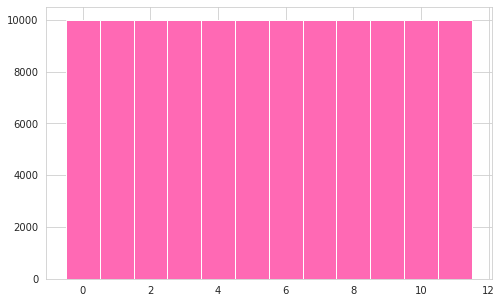

In [111]:
plt.hist(Ytrain,n, color = ("hotpink"))

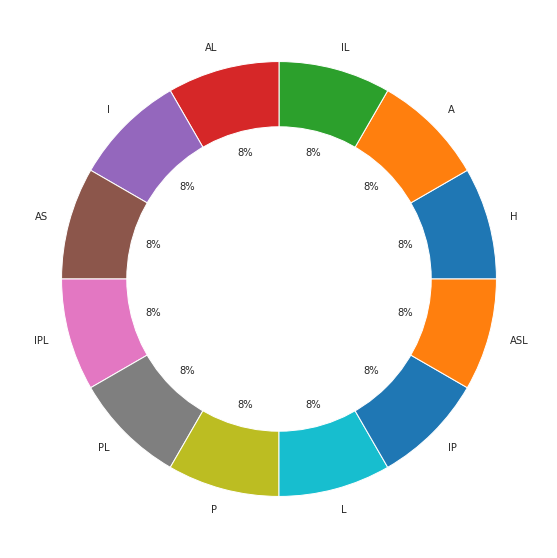

In [112]:
num_class = np.zeros(12)
for i in Ytrain:
    for j in range(12):
        if i==j:
            num_class[j]+=1

plt.figure(figsize= (10,10))
my_circle = plt.Circle((0,0), 0.7, color = 'white')

plt.pie(num_class, labels=['H', 'A', 'IL', 'AL', 'I', 'AS', 'IPL', 'PL', 'P', 'L', 'IP', 'ASL'], autopct = '%0.0f%%')
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [113]:
print('shape train before: ',Xtrain.shape)
Xtrain = Xtrain.reshape(Xtrain.shape[0],Xtrain[0].size,1)
print('shape train after: ',Xtrain.shape)
print('shape validation before: ',Xval.shape)
Xval = Xval.reshape(Xval.shape[0],Xval[0].size,1)
print('shape validation before: ',Xval.shape)
input_shape = (Xtrain[0].size,1)

batch_size = 64
epochs = 50

shape train before:  (120000, 650)
shape train after:  (120000, 650, 1)
shape validation before:  (7635, 650)
shape validation before:  (7635, 650, 1)


In [114]:
#transform integer label into one-hot encodings
n_classes=12

Ytrain_cat = keras.utils.to_categorical(Ytrain, n_classes)
Yval_cat = keras.utils.to_categorical(Yval, n_classes)
Ytest_cat = keras.utils.to_categorical(Ytest, n_classes)

In [116]:
Xtrain = np.asarray(Xtrain).astype('float32')
Xval = np.asarray(Xval).astype('float32')

In [117]:
# regl1 = regularizers.l1(0.01)
np.random.seed(12345)
# ini = initializers.RandomNormal(mean = 0, stddev = 0.05)
opt = optimizers.SGD(lr = 0.01, momentum = 0.9, nesterov = True, decay = 1e-6)
model0 = create_model(opt)

fit = model0.fit(Xtrain, Ytrain_cat,
               batch_size = batch_size, epochs = epochs,
               validation_data = (Xval, Yval_cat),
               verbose = 1, shuffle = True)

SGD0 = np.array((fit.history["accuracy"],
                       fit.history['val_' + "accuracy"],
                       fit.history["loss"], fit.history['val_' + "loss"]))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 646, 64)           384       
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 644, 128)          24704     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 322, 128)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 322, 128)          0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 310, 128)          213120    
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 304, 256)          229632    
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 152, 256)         

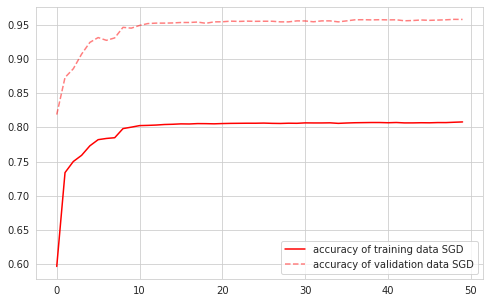

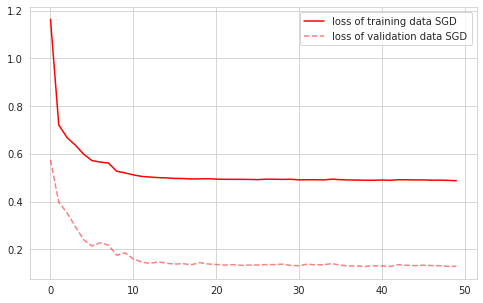

In [118]:
i=0
plt.plot(SGD0[i], 'r', label = 'accuracy of training data SGD')
plt.plot(SGD0[i+1], 'r--', label = 'accuracy of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()

i=2
plt.plot(SGD0[i], 'r', label = 'loss of training data SGD')
plt.plot(SGD0[i+1], 'r--', label = 'loss of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()

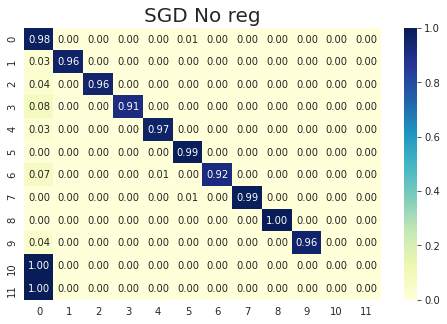

In [119]:
import sklearn.metrics as skm
from sklearn.metrics import plot_confusion_matrix

test = Xtest.reshape(Xtest.shape[0],Xtest[0].size,1)
y_val_vect = Ytest.astype(int)
y_predict  = np.argmax(model0.predict(test.astype(float)), axis=-1)

confusion_matrix  = skm.confusion_matrix(y_val_vect ,y_predict, normalize='true')

ax = sns.heatmap(confusion_matrix, annot=True, fmt = '.2f', cmap="YlGnBu")
ax.set_title('SGD No reg', fontsize=20)
plt.show()

Come si osserva dai grafici abbiamo un evidente overfitting che comporta il mismatch dei dati con label 10 e 11 (IP, ASL) confondendoli sempre con quelli sani H.

# Prove con layer di dropout e data augmentation
Si è dunque deciso di aggiungere un altro layer di dropout per evitare l'overfitting dei dati.

In [73]:
def create_model1(optimizer, activation='relu'):
    model = Sequential()
    model.add(Conv1D(64, 5, strides=1, input_shape = input_shape, activation=activation))
    model.add(Conv1D(128, 3, strides=1, activation=activation))
    model.add(MaxPool1D(pool_size=2, strides=2))
    model.add(Dropout(0.2))
    model.add(Conv1D(128, 13, strides=1, activation=activation))
    model.add(Conv1D(256, 7, strides=1, activation=activation))
    model.add(MaxPool1D(pool_size=2, strides=2))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(12, activation = activation))
    model.add(Softmax())
    
    print(model.summary())

    model.compile(loss = keras.losses.categorical_crossentropy, optimizer = optimizer, metrics = ['accuracy']) 
    
    return model

In [74]:
# regl1 = regularizers.l1(0.01)
np.random.seed(12345)
# ini = initializers.RandomNormal(mean = 0, stddev = 0.05)
opt = optimizers.SGD(lr = 0.01, momentum = 0.9, nesterov = True, decay = 1e-6)
model1 = create_model1(opt)

fit = model1.fit(Xtrain, Ytrain_cat,
               batch_size = batch_size, epochs = epochs,
               validation_data = (Xval, Yval_cat),
               verbose = 1, shuffle = True)

SGD1 = np.array((fit.history["accuracy"],
                       fit.history['val_' + "accuracy"],
                       fit.history["loss"], fit.history['val_' + "loss"]))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 646, 64)           384       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 644, 128)          24704     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 322, 128)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 322, 128)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 310, 128)          213120    
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 304, 256)          229632    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 152, 256)         

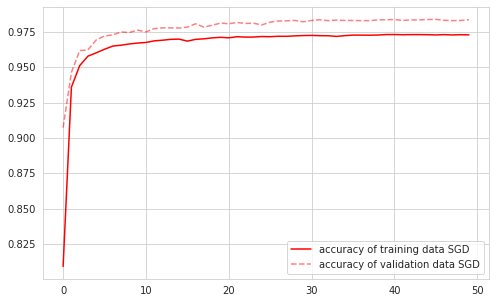

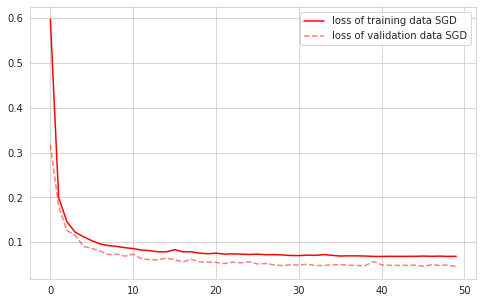

In [76]:
i=0
plt.plot(SGD1[i], 'r', label = 'accuracy of training data SGD')
plt.plot(SGD1[i+1], 'r--', label = 'accuracy of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()

i=2
plt.plot(SGD1[i], 'r', label = 'loss of training data SGD')
plt.plot(SGD1[i+1], 'r--', label = 'loss of validation data SGD', alpha=0.5)
plt.legend() 
plt.show()

Abbiamo un principio di overfitting

In [77]:
test = Xtest.reshape(Xtest.shape[0],Xtest[0].size,1)

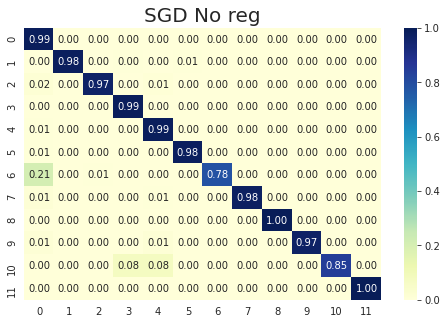

In [81]:
import sklearn.metrics as skm
from sklearn.metrics import plot_confusion_matrix

y_val_vect = Ytest.astype(int)
y_predict  = np.argmax(model1.predict(test.astype(float)), axis=-1)

confusion_matrix  = skm.confusion_matrix(y_val_vect ,y_predict, normalize='true')

ax = sns.heatmap(confusion_matrix, annot=True, fmt = '.2f', cmap="YlGnBu")
ax.set_title('SGD No reg', fontsize=20)
plt.show()

Il secondo layer di dropout è stato efficace nel diminuire l'overfitting ed infatti in questo caso la confusion matrix alte concentrazioni lungo la diagonale principale.
Tuttavia la rete proposta è molto ampia, con 934796 parametri, siamo nel caso del Deep Double Descent, si è perciò deciso di diminuire i parametri fino al di sotto del numero dei dati (120000 con data augmentation) per analizzare più agevolmente la rete.